In [ ]:
# This script is confirmed under python 3.6.12
# the libraries belowd are required
#       scikit-learn ver.0.23.2
#       scikit-bio ver.0.5.4
#       stats v.0.1

In [63]:
# Import libraries required for data analysis and plotting
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [64]:
# Load phenotype data and OTU tables
metadata=pd.read_csv("metadata.csv",encoding='cp1252',sep=',',header=0)
otu_rdp_assigned=pd.read_csv("otu_table.csv",encoding='cp1252',sep=',')
## get the list of cluster names
otu_genus=otu_rdp_assigned.iloc[:,0]

In [65]:
# preprocess microbiome data
## check data dimension
otu_rdp_assigned.shape
## fliter the OTU with greater than 100 reads
otu_rdp_assigned=otu_rdp_assigned.iloc[np.argwhere(otu_rdp_assigned.iloc[:,1:].apply(sum,axis=1)>=100).flatten(),:]
otu_tab=otu_rdp_assigned.iloc[:,1:]
otu_tab['genus']=otu_genus
otu_genus_collapsed=otu_tab.groupby('genus').sum()
## keep only genus which were present in greater than 5% of samples
otu_genus_dat=otu_genus_collapsed[otu_genus_collapsed.iloc[:,1:].apply(lambda x:sum(1*(x>0)),axis=1)>6]
otu_genus_dat=otu_genus_dat.iloc[1:,:]
## calculate relative abundance of each OTU by dividing its value by the total reads per sample
tot=otu_tab.sum(axis=0)[0:-1]
otu_genus_frac=otu_genus_dat.divide(tot,axis=1)
otu_genus_frac.head()

,Ig9373,Ig9374,Ig9375,Ig9376,Ig9377,Ig9378,Ig9379,Ig9380,Ig9381,Ig9382,...,Ig9469,Ig9470,Ig9471,Ig9472,Ig9473,Ig9474,Ig9475,Ig9476,Ig9477,Ig9478
genus,,,,,,,,,,,,,,,,,,,,,
Cluster_134,0,0,0.000350754,0.00104969,0,0,0.00209937,0,0,0.000351617,...,0,0.00069979,0.00526685,0,0.000356506,0.000347584,0.00069541,0,0.00141343,0
Cluster_14,0.030156,0.0828961,0.0589267,0.0409377,0.0777039,0.0156958,0.0325402,0.0468425,0.079104,0.0182841,...,0.0103591,0.0304409,0.0452949,0.0501066,0.028877,0.0177268,0.0149513,0.0205289,0.0480565,0.0258865
Cluster_15,0.113692,0.0115425,0.0217468,0.0206438,0.00630032,0.0163934,0.0538838,0.0541291,0.0584529,0.0583685,...,0.00759669,0.0118964,0.00245787,0.0636105,0.0730838,0.0100799,0.0278164,0.0142658,0.0279152,0.0304965
Cluster_16,0.00138648,0.000349773,0.0357769,0.0356893,0,0.00592954,0.0125962,0.018737,0.000350018,0.0116034,...,0.000690608,0.00279916,0.00210674,0,0.00677362,0.0243309,0.0100834,0.0111343,0.00388693,0.00531915
Cluster_168,0,0,0.00140302,0.00069979,0.00105005,0,0.00069979,0,0,0,...,0,0.00069979,0.00175562,0.00461976,0,0.000347584,0.000347705,0,0.000353357,0


In [66]:
# Visualize data using a dimension reduction method, PCoA
## import required libraries
from skbio.stats.distance import DistanceMatrix
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
## a list of samples IDs
ids=list(otu_genus_frac.columns)
## transpose OTU fraction matrix
data=np.array(otu_genus_frac.transpose())
## compute Bray_Curtis dissimilarity and get results in distance matrix format
bc_dm=beta_diversity(metric="braycurtis",counts=data,ids=ids)
## match class information of the samples from metadata
subset=metadata[['Samples','Malodour']]
ids_md=subset[subset['Samples'].isin(ids)]
ids_md=ids_md.set_index('Samples')
## conduct PCoA and print a 3D-plot
bc_pc=pcoa(bc_dm)
fig=bc_pc.plot(ids_md,'Malodour',axis_labels=('PC 1','PC 2','PC 3'),cmap=plt.cm.RdYlGn,s=1)

col_0,0,1,2,3,4,5,6,7,8,9
Malodour,,,,,,,,,,
N,8,8,8,3,6,5,4,1,2,0
P,2,1,6,3,3,6,3,6,3,12


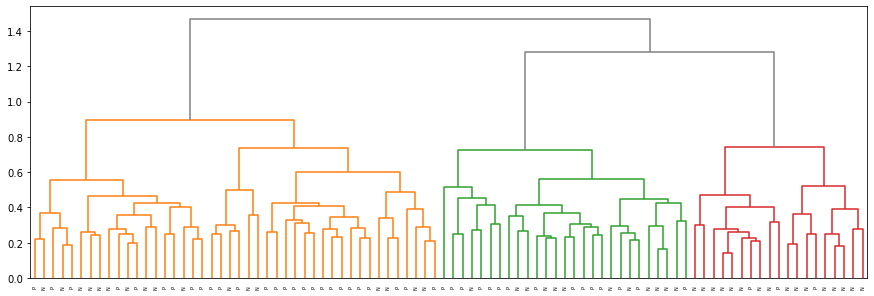

In [68]:
# Clustering samples using hierarchical clustering
## convert matrix to vector
lm=bc_dm.condensed_form()
## import hierarchy function
from scipy.cluster import hierarchy
## conduct hierarchical clustering
Z=hierarchy.linkage(lm,'ward')
plt.figure(figsize=(15,5))
hierarchy.dendrogram(Z,labels=ids_md['Malodour'],above_threshold_color='gray')
## cut tree to make cluster of give numbers
cutree=hierarchy.cut_tree(Z,n_clusters=10)
## cross-tabulate the cluster outcome and Malodour factor
pd.crosstab(ids_md['Malodour'],cutree.flatten())

In [69]:
# Preprocess metadata and split data into training and test sets
## shape microbiome data for modeling predictors
otu_model=otu_genus_frac.transpose()
otu_model=otu_model.reset_index()
otu_model=otu_model.rename(columns={'index':'Samples'})
dat=otu_model.merge(metadata[['Samples','Malodour']],on='Samples',how='inner')
dat.head()

,Samples,Cluster_134,Cluster_14,Cluster_15,Cluster_16,Cluster_168,Cluster_17,Cluster_175,Cluster_18,Cluster_19,...,Cluster_54,Cluster_55,Cluster_59,Cluster_644,Cluster_81,Cluster_85,Cluster_87,Cluster_88,Cluster_91,Malodour
0,Ig9373,0,0.030156,0.113692,0.00138648,0,0.0155979,0.0277296,0.182322,0.0246101,...,0.00450607,0.00519931,0.00034662,0,0.0110919,0.00485269,0,0,0,N
1,Ig9374,0,0.0828961,0.0115425,0.000349773,0,0,0.000349773,0.181532,0.0129416,...,0.00314795,0.0038475,0,0,0.000699545,0,0.00209864,0.000349773,0.000349773,N
2,Ig9375,0.000350754,0.0589267,0.0217468,0.0357769,0.00140302,0,0.000350754,0.191863,0.0526131,...,0.021396,0.00526131,0,0,0.000350754,0.0038583,0.0438443,0.000350754,0.000701508,N
3,Ig9376,0.00104969,0.0409377,0.0206438,0.0356893,0.00069979,0.0069979,0.000349895,0.308607,0.0486354,...,0.00069979,0.000349895,0,0,0.000349895,0,0.00104969,0,0.00209937,N
4,Ig9377,0,0.0777039,0.00630032,0,0.00105005,0.000700035,0,0.19041,0.0276514,...,0.00455023,0.000350018,0,0,0.00105005,0.000700035,0.000350018,0,0.000350018,N


In [71]:
## define x and y variables
x=dat.drop(['Malodour'],axis=1)
y=dat['Malodour']
## set index
x=x.set_index('Samples')
y=y.reset_index(drop=True)
## data normalization
from sklearn import preprocessing
scaler=preprocessing.StandardScaler()
norm_x=scaler.fit_transform(x)
names=x.columns
norm_x_df=pd.DataFrame(norm_x,columns=names)
## convert Malodour values to binary integers
y_tmp=(y=='P')*1
## split the data into 80 t0 20
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(norm_x_df,y_tmp,test_size=0.2,random_state=42)
## view the counts of case and control samples in the training set
pd.crosstab(y_train,columns=0)

col_0,0
Malodour,
0,36
1,36


Training Accuracy:0.944444
Test Accuracy:0.888889


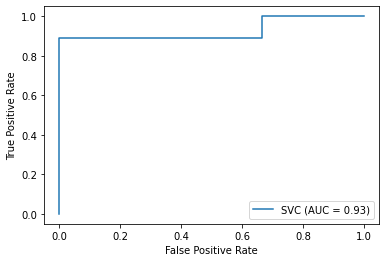

In [72]:
# Building a prediction model using SVM
## import package
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
## range of values to try for gamma and C
Cs=[0.0001,0.001,0.01,0.1,1,2,5,10,100]
gammas=[0.0001,0.001,0.01,0.1,1]
nfolds=5
param_grid={'C':Cs,'gamma':gammas}
## search for the best parameter values using cross-validation {'C':5,'gamma':0.001}
grid_search=GridSearchCV(SVC(kernel='rbf'),param_grid,cv=nfolds)
grid_search.fit(X_train,y_train)
grid_search.best_params_
## model building with the determined parameters
clf=SVC(C=5,gamma=0.001)
clf.fit(X_train,y_train)
## get the model accuracy in training and testing dataset
print("Training Accuracy:%f"%clf.score(X_train,y_train))
print("Test Accuracy:%f"%clf.score(X_test,y_test))
## compute AUC and plot ROC metric as classification model evaluation measures
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
plot_roc_curve(clf,X_test,y_test)